### Step 1: Listing all HID devices

Before we can use a HID device, we need to know its vendor ID, product ID, or name. The `list_hid_devices()` method in the `GamepadController` class can be used to list all connected HID devices along with their vendor IDs, product IDs, and names:


In [1]:
from controller import GamepadController
GamepadController.list_hid_devices()

0x004c:0x026c Magic Keyboard with Numeric Keypad
0x05ac:0x027e Apple Internal Keyboard / Trackpad
0x05ac:0x027e Apple Internal Keyboard / Trackpad
0x05ac:0x027e Apple Internal Keyboard / Trackpad
0x05ac:0x027e Apple Internal Keyboard / Trackpad
0x05ac:0x027e Apple Internal Keyboard / Trackpad
0x05ac:0x027e Apple Internal Keyboard / Trackpad
0x05ac:0x027e Apple Internal Keyboard / Trackpad
0x05ac:0x027e Apple Internal Keyboard / Trackpad
0x05ac:0x027e Apple Internal Keyboard / Trackpad
0x05ac:0x027e Apple Internal Keyboard / Trackpad
0x046d:0xc542 Wireless Receiver
0x046d:0xc542 Wireless Receiver
0x046d:0xc542 Wireless Receiver
0x05ac:0x8262 Ambient Light Sensor
0x05ac:0x8102 Touch Bar Backlight
0x05ac:0x8102 Touch Bar Backlight
0x05ac:0x8103 Headset
0xe502:0xbbab ExpressLRS Joystick
0xe502:0xbbab ExpressLRS Joystick
0xe502:0xbbab ExpressLRS Joystick
0x05ac:0x8600 TouchBarUserDevice
0x05ac:0x8302 Touch Bar Display
0x05ac:0x8302 Touch Bar Display
0x05ac:0x8302 Touch Bar Display
0x004c:0x

### Step 2: Connecting to a HID device
Once we know the vendor ID, product ID, or name of our game controller, we can use the connect() method to establish a connection:


In [2]:
import hid
gamepad = hid.device()
gamepad_controller = GamepadController(gamepad)
#controller.connect(vendor_id=<vendor_id>, product_id=<product_id>)  # Replace with actual IDs
# OR
gamepad_controller.connect(name="ExpressLRS Joystick")  # Replace with actual name

Connecting to {'path': b'DevSrvsID:4295206353', 'vendor_id': 58626, 'product_id': 48043, 'serial_number': '0123456789', 'release_number': 4097, 'manufacturer_string': 'ELRS', 'product_string': 'ExpressLRS Joystick', 'usage_page': 1, 'usage': 5, 'interface_number': -1}



### Step 3: Understanding the raw output from the controller and the two-value transmission per channel
To better understand the raw output data from the HID device, you can use the print_raw_data() method

In [4]:
from IPython.display import clear_output
# code below should run for about 25 seconds you can increase the time by changing 50 iterations to higher number
i=0
while i in range(0,50):
    clear_output(wait=True)
    GamepadController.print_raw_data(gamepad)
    i=i+1
#To identify which channels correspond to which controller inputs, you can experiment by moving different parts of your controller and observing the changes in the raw data output. This will help you identify which indexes correspond to which controller inputs.
gamepad_controller.disconnect()

0 :  3
1 :  0
2 :  0
3 :  89
4 :  64
5 :  205
6 :  63
7 :  19
8 :  0
9 :  9
10 :  64
11 :  90
12 :  49
13 :  225
14 :  63
15 :  255
16 :  127
17 :  19
18 :  0
19 :  0



### Step 4: Identifying controller channels and configuring them
The GamepadController class allows you to define channels such as throttle, roll, yaw, and pitch. After identifying the channels by observing the changes in raw data output during different controller inputs, you can define the channels as follows:


In [1]:
from controller import GamepadController
import hid
import time
# configuration below has been made by me and it works with Radiomaster TX16S with ELRS Radiomaster micro module
# You have to adjust it to your device, especially: 'vendor_id','product_id','name', and 'channels'
conf={'vendor_id':0xe502,'product_id':0xbbab,'name':'ExpressLRS Joystick','min_value':19, 'max_value':32640,'deadzone_width':150,'channels':{'throttle': 11, 'yaw': 13, 'roll': 3, 'pitch': 5, 'channel_5': 7,'channel_6': 9,'channel_7': 15,'channel_8': 17}}
gamepad = hid.device() # I had to define it outside the class. Some quirks of HID module cause objects created within function unable to open connection
gamepad_controller = GamepadController(gamepad,conf['channels'],conf['min_value'],conf['max_value'],conf['deadzone_width']).connect(name=conf['name'])
time.sleep(1)
controller_state = gamepad_controller.read_controller()
print(controller_state)
gamepad_controller.disconnect()

Connecting to {'path': b'DevSrvsID:4295206353', 'vendor_id': 58626, 'product_id': 48043, 'serial_number': '0123456789', 'release_number': 4097, 'manufacturer_string': 'ELRS', 'product_string': 'ExpressLRS Joystick', 'usage_page': 1, 'usage': 5, 'interface_number': -1}
{'throttle': 12585, 'yaw': 16290, 'roll': 16409, 'pitch': 16270, 'channel_5': 19, 'channel_6': 16329, 'channel_7': 32640, 'channel_8': 19}


### Step 5: Writing a method to control a robot using the game controller
With the ability to read the state of the game controller, you can now use this information to control a robot. The following is a simple pseudocode example of how to do this:

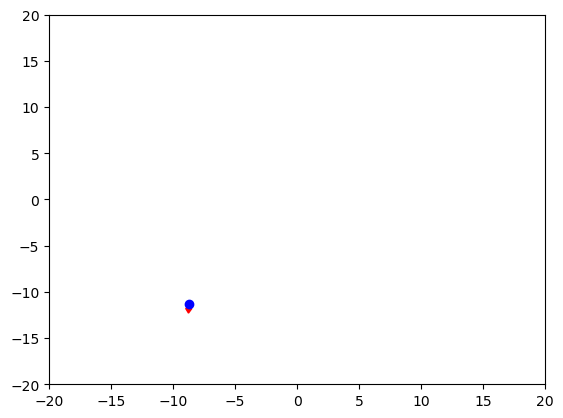

In [5]:
from IPython.display import clear_output, display
import ipywidgets as widgets
import math
import matplotlib.pyplot as plt
import time
from controller import GamepadController
import hid
import time
class Robot:
    def __init__(self, x=0, y=0):
        self.x = x
        self.y = y
        self.direction = 0  # Direction in degrees, with 0 being to the right (east)
        self.fig, self.ax = plt.subplots()
        self.ax.set_xlim(-20, 20)
        self.ax.set_ylim(-20, 20)
        self.point, = self.ax.plot([self.x], [self.y], 'bo')
        self.arrow = self.ax.arrow(self.x, self.y, 0.5*math.cos(math.radians(self.direction)), 0.5*math.sin(math.radians(self.direction)),  fc='r', ec='r') #head_width=0.5, head_length=0.5,

    def move_forward(self, speed):
        self.x += speed * 0.1 * math.cos(math.radians(self.direction))
        self.y += speed * 0.1 * math.sin(math.radians(self.direction))
        self.visualize()

    def turn(self, angle_change):
        self.direction += angle_change
        self.visualize()

    def visualize(self):
        self.point.set_data([self.x], [self.y])
        self.arrow.remove()
        self.arrow = self.ax.arrow(self.x, self.y, 0.5*math.cos(math.radians(self.direction)), 0.5*math.sin(math.radians(self.direction)), head_width=2, head_length=2, fc='r', ec='r')
        clear_output(wait=True)
        display(self.fig)

# configuration below has been made by me and it works with Radiomaster TX16S with ELRS Radiomaster micro module
# You have to adjust it to your device, especially: 'vendor_id','product_id','name', and 'channels'
conf={'vendor_id':0xe502,'product_id':0xbbab,'name':'ExpressLRS Joystick','min_value':19, 'max_value':32640,'deadzone_width':150,'channels':{'throttle': 11, 'yaw': 13, 'roll': 3, 'pitch': 5, 'channel_5': 7,'channel_6': 9,'channel_7': 15,'channel_8': 17}}
gamepad = hid.device() # I had to define it outside the class. Some quirks of HID module cause objects created within function unable to open connection
gamepad_controller = GamepadController(gamepad,conf['channels'],conf['min_value'],conf['max_value'],conf['deadzone_width']).connect(name=conf['name'])
time.sleep(1)
controller_state = gamepad_controller.read_controller()
print(controller_state)

robot = Robot()
for i in range(0,100):
    # Read the controller state
    controller_state = gamepad_controller.read_controller()
    time.sleep(0.1)
    # Get the state of the throttle and yaw channels
    throttle = gamepad_controller.get_percentage_channel_value('throttle')
    yaw = gamepad_controller.get_percentage_channel_value('yaw')
    
    # Use the throttle and yaw values to control the robot
    robot.move_forward(throttle)
    robot.turn(yaw)
    
    # Wait a short period of time before the next iteration
    time.sleep(0.1)
clear_output(wait=True)
gamepad_controller.disconnect()